In [1]:
import torch
from torchvision import transforms, models
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn
from PIL import Image

import urllib
import os
import glob


if torch.cuda.is_available():
    num_devs = torch.cuda.device_count()
    print(f"Number of GPUs: {num_devs}")
    dev_num = torch.cuda.current_device()
    gpu_type = torch.cuda.get_device_name(dev_num)
    print(f"Current GPU: {gpu_type}")
else:
    print("No GPU found, using CPU")

Number of GPUs: 1
Current GPU: NVIDIA L40S


In [2]:
# !pip install git+https://github.com/joefutrelle/pyifcb
import ifcb

## Load the trained model (weights + structure)

Model is trained on Resnet18 with 6 classes:
1. Ceratium furca
2. Prorocentrum graciles
3. Akashiwo
4. Eucampia
5. Laboea
6. Dinophysis

Each class is trained with 400 images.


## Load Model

In [3]:

# Load checkpoint
checkpoint_path = "../model/resnet18-6class.pth"
checkpoint = torch.load(checkpoint_path, map_location=torch.device("cuda"),weights_only=False)  # or "cuda" if available

# Recreate the model architecture
model = models.resnet18(weights=False)

# Modify first conv layer if input was grayscale
if checkpoint.get("input_channels", 3) == 1:
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Modify final FC layer
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, checkpoint["num_classes"])

# Load weights
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

# Restore class labels
class_to_idx = checkpoint["class_to_idx"]
idx_to_class = {v: k for k, v in class_to_idx.items()}

print("Model loaded and ready for inference")

Model loaded and ready for inference


/opt/conda/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Download some test images from the Dashboard

Some of these data are specifically __Out-of-Distribution__

- The __Ceratium__ species is different enough that it may be confused.
- The other images are not repsented in the model by a class at all

---
Feel free to add more images here to test model performance. Just adding a URL to the list will will download it locally.

In [4]:
fnames = ["https://ifcb.caloos.org/mbari-power-buoy/D20250531T012459_IFCB161_00696.png",
          "https://ifcb.caloos.org/mbari-power-buoy/D20250531T012459_IFCB161_01013.png",
         "https://ifcb.caloos.org/mbari-power-buoy/D20250531T012459_IFCB161_00521.png",
         "https://ifcb.caloos.org/mbari-power-buoy/D20250531T012459_IFCB161_01227.png",
          "https://ifcb.caloos.org/mbari-power-buoy/D20250531T012459_IFCB161_01384.png",
          "https://ifcb.caloos.org/mbari-power-buoy/D20250531T012459_IFCB161_00538.png",
          "https://ifcb.caloos.org/mbari-power-buoy/D20250531T012459_IFCB161_00045.png",
          "https://ifcb.caloos.org/mbari-power-buoy/D20250531T012459_IFCB161_01661.png",
          "https://ifcb.caloos.org/mbari-power-buoy/D20250531T012459_IFCB161_00746.png",
          "https://ifcb.caloos.org/mbari-power-buoy/D20250531T012459_IFCB161_01383.png"
         ]

for fname in fnames:
  save_name = fname.split("/")[-1]
  urllib.request.urlretrieve(fname, filename=os.path.join("../test-images",save_name))

## Load Images

Find all of the loaded images.

In [5]:
fnames = glob.glob("../test-images/*.png")
fnames

['../test-images/D20250531T012459_IFCB161_00538.png',
 '../test-images/D20250531T012459_IFCB161_00045.png',
 '../test-images/D20250531T012459_IFCB161_00746.png',
 '../test-images/D20250531T012459_IFCB161_01383.png',
 '../test-images/D20250531T012459_IFCB161_01013.png',
 '../test-images/D20250531T012459_IFCB161_01384.png',
 '../test-images/D20250531T012459_IFCB161_01227.png',
 '../test-images/D20250531T012459_IFCB161_01661.png',
 '../test-images/D20250531T012459_IFCB161_00696.png',
 '../test-images/D20250531T012459_IFCB161_00521.png']

In [6]:
# Transforms for ResNet18 (ImageNet compatible)
# Very important to normalize to whatever the model weights were originally normalized to
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,), (0.228,))
])

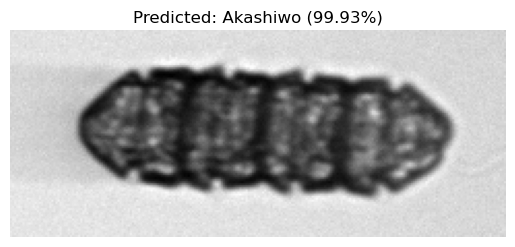

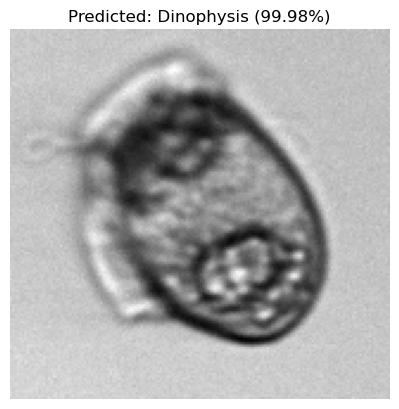

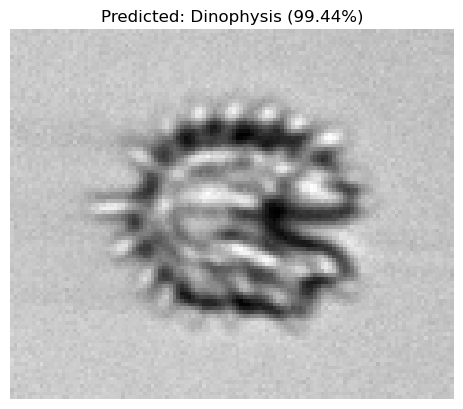

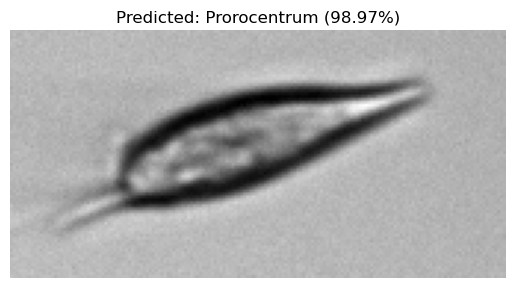

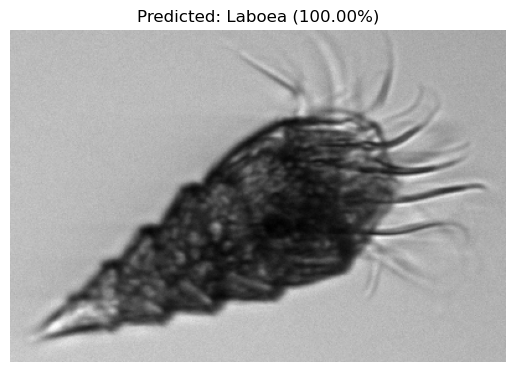

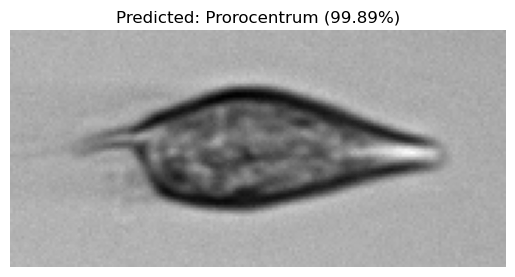

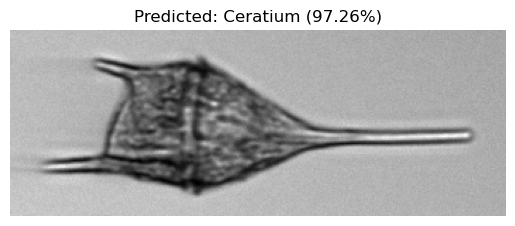

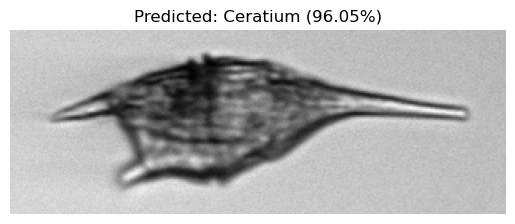

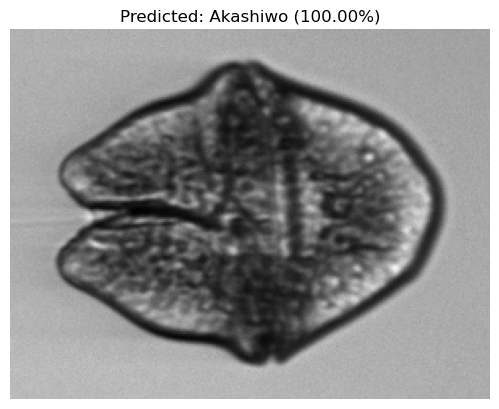

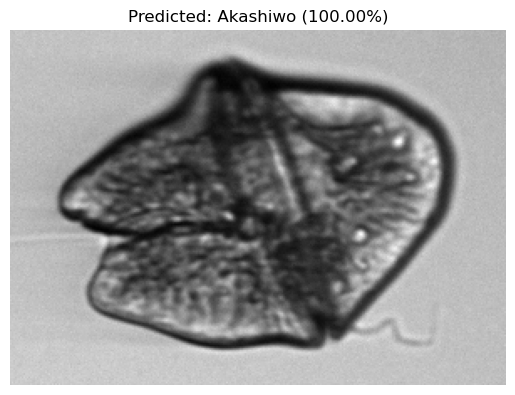

In [7]:
import matplotlib.pyplot as plt

for img_path in fnames:
    image = Image.open(img_path).convert("L")
    input_tensor = transform(image).unsqueeze(0)

    with torch.no_grad():
        output = model(input_tensor)
        probs = F.softmax(output, dim=1)
        prob, pred_idx = torch.max(probs, dim=1)
        pred_class = idx_to_class[pred_idx.item()]
        prob_val = prob.item()
    
    # Show image with label
    plt.imshow(image, cmap="gray")
    plt.title(f"Predicted: {pred_class} ({prob_val:.2%})")
    plt.axis("off")
    plt.show()

# This is illustrates a very important point #
The model does not inherently know how to handle phytoplankton classes that it was not trained on. All it can do is give it its best guess based on the trained data.